In [1]:
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import os

rnd = 42
np.random.seed(rnd)
torch.manual_seed(rnd)

In [22]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/adult_clear.csv')
df = df[df["workclass"] != "?"]
df = df[df["occupation"] != "?"]
df = df[df["native-country"] != "?"]
df.replace(['Divorced', 'Married-AF-spouse',
            'Married-civ-spouse', 'Married-spouse-absent',
            'Never-married', 'Separated', 'Widowed'],
           ['notmarried', 'married', 'married', 'married',
            'notmarried', 'notmarried', 'notmarried'], inplace=True)
df['education'].replace(['Preschool', '10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th'], 'dropout',
                        inplace=True)
df['education'].replace(['HS-Grad', 'HS-grad'], 'HighGrad', inplace=True)
df['education'].replace(['Some-college', 'Assoc-acdm', 'Assoc-voc'], 'CommunityCollege', inplace=True)
df = df[df.race == 'White']
# excludes 10 observations
df = df[df['workclass'] != 'Never-worked']
# excludes 14 observations
df = df[df['occupation'] != 'Armed-Forces']
# excludes 21 observations
df = df[df['workclass'] != 'Without-pay']
df.drop(['fnlwgt', 'educational-num', 'relationship', 'race', 'capital-gain', 'capital-loss'],
            axis=1, inplace=True)
df['workclass'].replace(['Local-gov', 'State-gov', 'Federal-gov'], 'Gov', inplace=True)
df['workclass'].replace(['Private', 'Self-emp-not-inc', 'Self-emp-inc'], 'Private', inplace=True)
df['occupation'].replace(
    ['Craft-repair', 'Machine-op-inspct', 'Handlers-cleaners', 'Transport-moving', 'Adm-clerical',
     'Farming-fishing'], 'BlueCollar', inplace=True)
df['occupation'].replace(['Other-service', 'Protective-serv', 'Tech-support', 'Priv-house-serv'], 'Services',
                         inplace=True)
df['occupation'].replace(['Exec-managerial'], 'ExecManagerial', inplace=True)
df['occupation'].replace(['Prof-specialty'], 'ProfSpecialty', inplace=True)
df['education'].replace(['Prof-school'], 'ProfSchool', inplace=True)
df['native-country'].replace(['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', \
                              'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti',\
                              'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland',\
                              'Italy', 'Jamaica', 'Japan', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)',\
                              'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South',\
                              'Taiwan','Thailand', 'Trinadad&Tobago', 'Vietnam','Yugoslavia'], 'Non_US', inplace=True)
df.rename(columns={'hours-per-week': 'hoursPerWeek'}, inplace=True)
df.rename(columns={'marital-status': 'marital_status'}, inplace=True)
df.rename(columns={'native-country': 'native_country'}, inplace=True)
columns_titles = ["age","hoursPerWeek","education","marital_status","occupation","gender","native_country","income"]
df=df.reindex(columns=columns_titles)
df = df[~df.duplicated()]
X = df.copy()
# ord_enc = OrdinalEncoder()
# X.iloc[:,2:] = ord_enc.fit_transform(X.values[:,2:]).astype(int)
std = MinMaxScaler(feature_range=(-1,1))
X.iloc[:,:2] = std.fit_transform(X.values[:,:2])
hot_enc = OneHotEncoder(handle_unknown='ignore')
hot_enc.fit(X.iloc[:,[2,4]])
X[np.hstack(hot_enc.categories_).tolist()]=hot_enc.transform(X.iloc[:,[2,4]]).toarray().astype(int)
X.loc[:,'marital_status'] = (X.loc[:,'marital_status']=='married')+0
X.loc[:,'gender'] = (X.loc[:,'gender']=='male')+0
X.loc[:,'native_country'] = (X.loc[:,'native_country']=='United-States')+0
X.drop(['education'], axis=1, inplace=True)
X.drop(['occupation'], axis=1, inplace=True)
X.drop(['income'], axis=1, inplace=True)
y = df["income"].apply(lambda x: ">50K" in x).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rnd)

In [24]:
X_train

,age,hoursPerWeek,marital_status,gender,native_country,Bachelors,CommunityCollege,Doctorate,HighGrad,Masters,ProfSchool,dropout,BlueCollar,ExecManagerial,ProfSpecialty,Sales,Services
42164,-0.643836,0.408163,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
32793,-0.835616,-0.408163,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
38565,0.013699,0.204082,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
39668,-0.150685,-0.122449,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
7129,-0.506849,-0.204082,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22798,-0.808219,-0.020408,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
21465,-0.424658,-0.285714,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
38985,-0.041096,-0.204082,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
23117,-0.835616,-0.408163,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


XGBOOST
train acc: 0.7962507682851875
test acc: 0.7615535889872173
RF
train acc: 0.7771358328211432
test acc: 0.767944936086529
SVC
train acc: 0.7617086662569146
test acc: 0.7487708947885939


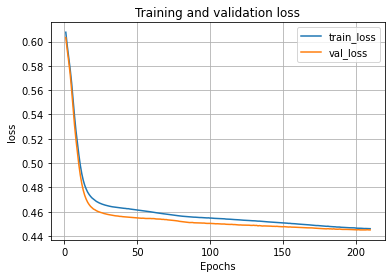

NN
509/509 [==============================] - 1s 901us/step
0.7750460971112477
128/128 [==============================] - 0s 953us/step
0.77015732546706
---------------


In [31]:
### XGBOOST

from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=60, reg_lambda=3, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)
pickle.dump(clf_xgb,open('./blackboxes/adult_xgboost.p','wb'))
clf_xgb = pickle.load(open('./blackboxes/adult_xgboost.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_xgb.predict_proba(x)[:,1].ravel()
    else: return clf_xgb.predict(x).ravel().ravel()
y_train_pred = predict(X_train)
y_test_pred = predict(X_test)
print('XGBOOST')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

### RF
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=7,random_state=rnd)
clf_rf.fit(X_train, y_train)
pickle.dump(clf_rf,open('./blackboxes/adult_rf.p','wb'))
clf_rf = pickle.load(open('./blackboxes/adult_rf.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_rf.predict_proba(x)[:,1].ravel()
    else: return clf_rf.predict(x).ravel().ravel()
y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)
print('RF')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

### SVC
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto', probability=True)
clf_svc.fit(X_train, y_train)
pickle.dump(clf_svc,open('./blackboxes/adult_svc.p','wb'))
clf_svc = pickle.load(open('./blackboxes/adult_svc.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_svc.predict_proba(x)[:,1].ravel()
    else: return clf_svc.predict(x).ravel().ravel()
y_train_pred = predict(X_train, return_proba=True)
y_test_pred = predict(X_test, return_proba=True)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

### NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)
clf_nn = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])
early_stopping = EarlyStopping(patience=5)
clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = clf_nn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0
    )
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
clf_nn.save_weights('./blackboxes/adult_tf_nn')
from sklearn.metrics import accuracy_score
clf_nn.load_weights('./blackboxes/adult_tf_nn')
clf_nn.trainable = False
def predict(x, return_proba=False):
    if return_proba:
        return clf_nn.predict(x).ravel()
    else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
print('NN')
print(accuracy_score(np.round(predict(X_train, return_proba = True)),y_train))
print(accuracy_score(np.round(predict(X_test, return_proba = True)),y_test))
print('---------------')

In [87]:
black_box = 'nn'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)

128/128 [==============================] - 0s 1ms/step


# Baseline 1-KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train_bb)

print(accuracy_score(neigh.predict(X_test),y_test_bb))

0.9894296951819076


# Proto Select

In [89]:
from alibi.prototypes import ProtoSelect
from alibi.utils.kernel import EuclideanDistance

summariser = ProtoSelect(kernel_distance=EuclideanDistance(), eps=5)
summariser = summariser.fit(X=X_train.values, y=y_train_bb)
summary = summariser.summarise(num_prototypes=10)

In [90]:
proto_select = pd.DataFrame(summary.prototypes, columns=X_train.columns)
proto_select

,age,hoursPerWeek,marital_status,gender,native_country,Bachelors,CommunityCollege,Doctorate,HighGrad,Masters,ProfSchool,dropout,BlueCollar,ExecManagerial,ProfSpecialty,Sales,Services
0,-0.643836,0.408163,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [91]:
proto_pred = predict(proto_select)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_select.values, X_test),axis=0)
d = {}
for i in range(len(proto_pred)):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_select.values,proto_select.values)))

1/1 [==============================] - 0s 42ms/step
perc positive proto:  0.0
accuracy 1-KNN: 0.76007866273353
avg_distance: 0.0


# ProtoDASH

In [92]:
X_train

,age,hoursPerWeek,marital_status,gender,native_country,Bachelors,CommunityCollege,Doctorate,HighGrad,Masters,ProfSchool,dropout,BlueCollar,ExecManagerial,ProfSpecialty,Sales,Services
42164,-0.643836,0.408163,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
32793,-0.835616,-0.408163,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
38565,0.013699,0.204082,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
39668,-0.150685,-0.122449,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
7129,-0.506849,-0.204082,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22798,-0.808219,-0.020408,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
21465,-0.424658,-0.285714,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
38985,-0.041096,-0.204082,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
23117,-0.835616,-0.408163,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [93]:
from protodash import ProtodashExplainer, get_Gaussian_Data

explainer = ProtodashExplainer()

# call protodash explainer
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(X_train.values, X_train.values, m=10) 

In [94]:
proto_dash = X_train.iloc[S, :].copy()
proto_dash

,age,hoursPerWeek,marital_status,gender,native_country,Bachelors,CommunityCollege,Doctorate,HighGrad,Masters,ProfSchool,dropout,BlueCollar,ExecManagerial,ProfSpecialty,Sales,Services
42554,-0.671233,-0.306122,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0
43012,0.835616,-0.693878,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
44875,-0.753425,0.612245,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0
43145,-1.000000,-0.918367,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
36317,0.205479,1.000000,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
10375,-0.753425,-0.204082,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
48035,-0.753425,0.612245,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
39563,0.479452,-0.448980,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
680,0.178082,-0.612245,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2078,-0.561644,1.000000,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [95]:
proto_pred = predict(proto_dash)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_dash.values, X_test),axis=0)
d = {}
for i in range(10):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_dash.values,proto_dash.values)))

1/1 [==============================] - 0s 23ms/step
perc positive proto:  0.1
accuracy 1-KNN: 0.7922812192723697
avg_distance: 2.230294926094308


# MMD Critic

In [96]:
from mmd.mmd_critic import Dataset, select_prototypes, select_criticisms

gamma = 0.026

num_prototypes = 10
num_criticisms = 10

kernel_type = 'local'
# kernel_type = 'global'

# regularizer = None
regularizer = 'logdet'
# regularizer = 'iterative'

d_train = Dataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(y_train_bb,dtype=torch.long))
if kernel_type == 'global':
    d_train.compute_rbf_kernel(gamma)
elif kernel_type == 'local':
    d_train.compute_local_rbf_kernel(gamma)
else:
    raise KeyError('kernel_type must be either "global" or "local"')
print('Done.', flush=True)

# Prototypes
print('Computing prototypes...', end='', flush=True)
prototype_indices = select_prototypes(d_train.K, num_prototypes)

prototypes = d_train.X[prototype_indices]
prototype_labels = d_train.y[prototype_indices]

sorted_by_y_indices = prototype_labels.argsort()
prototypes_sorted = prototypes[sorted_by_y_indices]
prototype_labels = prototype_labels[sorted_by_y_indices]
print('Done.', flush=True)
print(prototype_indices.sort()[0].tolist())

# Criticisms
print('Computing criticisms...', end='', flush=True)
criticism_indices = select_criticisms(d_train.K, prototype_indices, num_criticisms, regularizer)

criticisms = d_train.X[criticism_indices]
criticism_labels = d_train.y[criticism_indices]

sorted_by_y_indices = criticism_labels.argsort()
criticisms_sorted = criticisms[sorted_by_y_indices]
criticism_labels = criticism_labels[sorted_by_y_indices]
print('Done.', flush=True)
print(criticism_indices.sort()[0].tolist())

Done.
Computing prototypes...Done.
[3959, 6120, 6539, 6829, 6971, 7064, 9535, 9760, 12418, 13925]
Computing criticisms...Done.
[1993, 6682, 6844, 8739, 8766, 11974, 12169, 13590, 13728, 15845]


In [97]:
proto_mmd = X_train.iloc[prototype_indices.sort()[0].tolist()]
proto_mmd

,age,hoursPerWeek,marital_status,gender,native_country,Bachelors,CommunityCollege,Doctorate,HighGrad,Masters,ProfSchool,dropout,BlueCollar,ExecManagerial,ProfSpecialty,Sales,Services
2143,-0.369863,-0.204082,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
20323,-0.397260,-0.204082,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
43976,-0.342466,-0.204082,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
13877,-0.397260,-0.204082,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1
29543,-0.342466,-0.204082,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0
33396,-0.068493,0.204082,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
23751,-0.369863,-0.163265,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
31352,-0.397260,-0.204082,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
15084,-0.671233,0.204082,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0
2461,0.095890,-0.244898,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0


In [98]:
proto_pred = predict(proto_mmd)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_mmd.values, X_test),axis=0)
d = {}
for i in range(10):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_mmd.values,proto_mmd.values)))

1/1 [==============================] - 0s 24ms/step
perc positive proto:  0.2
accuracy 1-KNN: 0.8077679449360865
avg_distance: 1.7962944496657602


# Latent

In [99]:
X_train_latent = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test_latent = np.hstack((X_test,y_test_pred.reshape(-1,1)))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Latent Space

latent_dim = 6
batch_size = 1024
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3

idx_cat = list(range(2,17))

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train_latent.shape[1], latent_dim=latent_dim)

In [100]:
train_dataset = TensorDataset(torch.tensor(X_train_latent).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test_latent).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_adult.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_adult.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/adult_latent_{black_box}_{latent_dim}.pt')

Epoch: 243 Train Sim Loss 0.00028 Test Sim Loss 0.00029 Early Stopping 3


In [ ]:
model.load_state_dict(torch.load(f'./models/adult_latent_{black_box}_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

## Latent Clustering

In [71]:
np.mean(y_train==1)

0.29870928088506454

In [72]:
from sklearn.cluster import SpectralClustering, KMeans

Z_train_0 = Z_train[y_train==0]
Z_train_1 = Z_train[y_train==1]

n = 10

clustering_0 = SpectralClustering(n_clusters=int(n//(1/0.70)),assign_labels='discretize').fit(Z_train_0)
clustering_1 = SpectralClustering(n_clusters=int(n-n//(1/0.70)),assign_labels='discretize').fit(Z_train_1)

centers = []
for i in range(int(n//(1/0.70))):
    centers.append(np.mean(Z_train_0[clustering_0.labels_==i],axis=0))
for i in range(int(n-n//(1/0.70))):
    centers.append(np.mean(Z_train_1[clustering_1.labels_==i],axis=0))
centers = np.stack(centers)

from scipy.spatial.distance import cdist
idx = np.argmin(cdist(centers,Z_train),axis=1)
proto_latent_clustering = pd.DataFrame(X_train_latent[idx,:-1],columns=X_train.columns)

proto_pred = predict(proto_latent_clustering)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_latent_clustering.values, X_test_latent[:,:-1]),axis=0)
d = {}
for i in range(n):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_latent_clustering.values,proto_latent_clustering.values)))

perc positive proto:  0.2
accuracy 1-KNN: 0.806047197640118
avg_distance: 1.9175072203232575


In [50]:
import pickle
results = pickle.load(open('results_proto_adult.pickle','rb'))

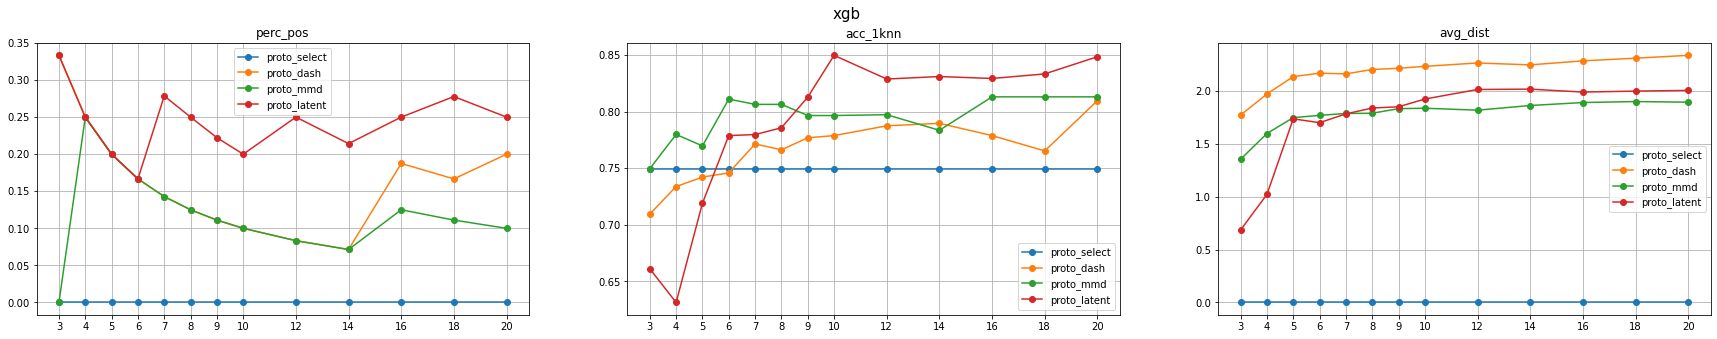

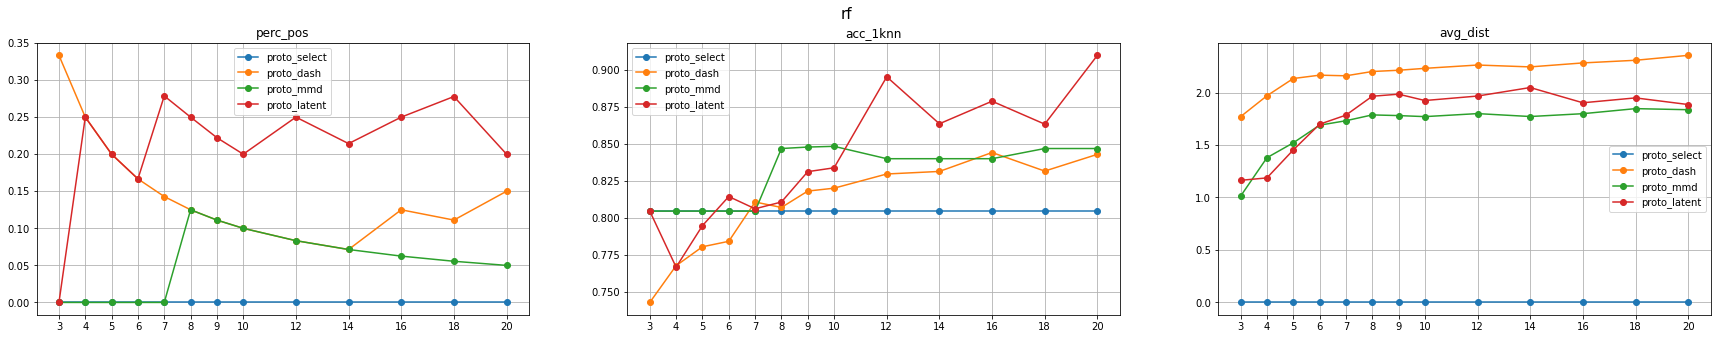

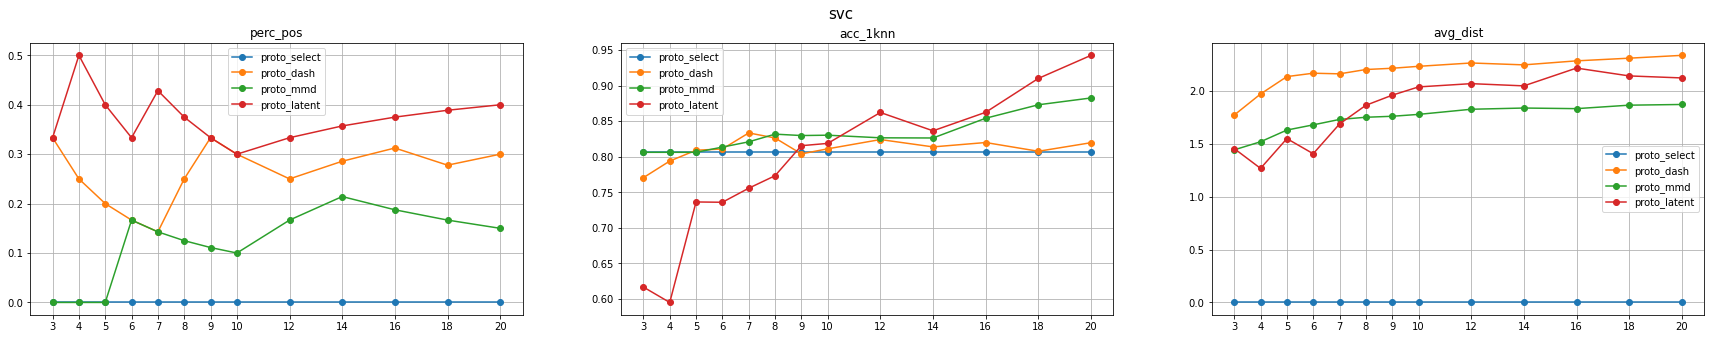

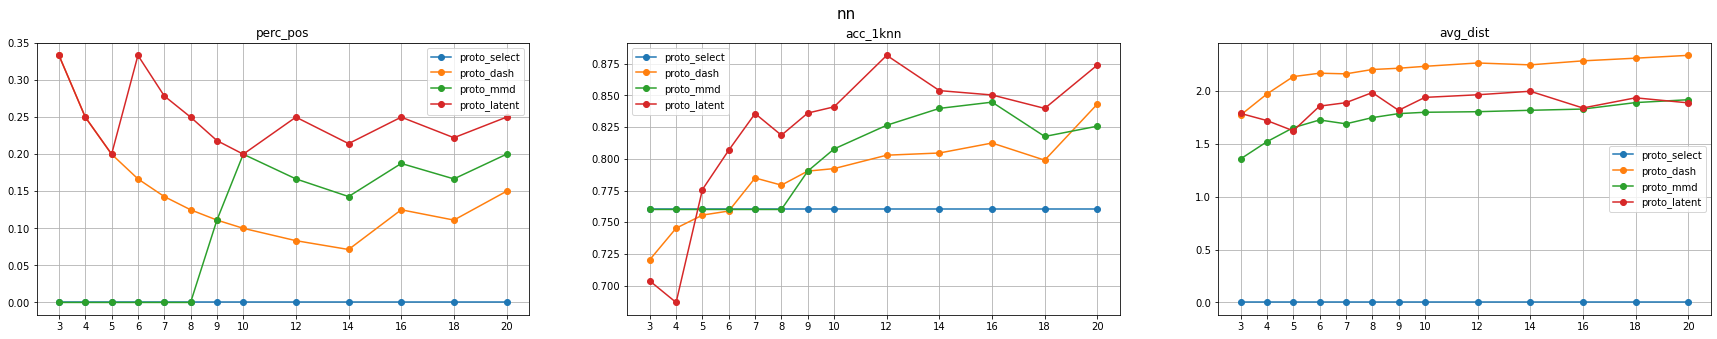

In [51]:
for bb in ['xgb', 'rf', 'svc', 'nn']:
    r =[]
    for method in ['proto_select', 'proto_dash', 'proto_mmd', 'proto_latent']:
        l = []
        for n in [3,4,5,6,7,8,9,10,12,14,16,18,20]:
            l.append([results[bb][method][f'n_{n}']['perc_pos'],results[bb][method][f'n_{n}']['acc_1knn'],results[bb][method][f'n_{n}']['avg_dist']])
        r.append(np.stack(l))
    r = np.stack(r)

    methods = ['proto_select', 'proto_dash', 'proto_mmd', 'proto_latent']

    fig, ax = plt.subplots(1,3,figsize=(30,5))
    fig.suptitle(bb, fontsize=15)

    for i in range(len(methods)):
        ax[0].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,0],'-o',label=methods[i])
        ax[1].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,1],'-o',label=methods[i])
        ax[2].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,2],'-o',label=methods[i])

    ax[0].set_title('perc_pos')
    ax[1].set_title('acc_1knn')
    ax[2].set_title('avg_dist')

    for i in range(3):
        ax[i].legend()
        ax[i].grid()
        ax[i].set_xticks([3,4,5,6,7,8,9,10,12,14,16,18,20])